In [163]:
#Overall game rules

#Goal: 10 Victory points

#Initialize board
#Random tile placements
#initialize robber

#Initialize players
    #5 settlements, 4 cities, 15 roads
#roll dice to determine order (Omitted, Adjusted in our implementation)
    #tie break with another roll
#in order greatest to least select first settlements
#in order least to greatest select second settlements
#add 1 of each adjacent material to each players bank (Adjusted in our implementation)
#remove those from the overall bank 

#next player in order of number 1,2,3,4
#roll dice
#if 7 have each player 
    #check their resources for >7 total
    #move the robber
#else
    #every player take their own resources from bank
#While possible actions is not empty
    #pick possible action
    #Possible actions
        #Build
        #Buy development card
        #Play development card
        #Trade

#move robber
    #change robber location
    #Take 1 random card from a player affected not self
    
#Rules
#Validate actions
#Hold, Build, Trade Port, Trade player, Buy DC, Play DC, Trade specific

In [ ]:
#Necessary modules
import datetime
import numpy as np
import random
from math import log, sqrt 
import copy
import pprint
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

In [162]:
#MonteCarlo class inspired by and adapted from http://jeffbradberry.com/posts/2015/09/intro-to-monte-carlo-tree-search/
#Edited by Evan Gray and Abby Tonkinson
#Adjusted to the data structure and processes of our Catan implementation


class MonteCarlo(object):
    # Initialize game states and statistics
    def __init__(self, b,random_state, **kwargs):
        #Copy the board since we do not want to actually change the real board but want the functionality
        self.board = copy.deepcopy(b)
        self.current_player = b.current_player
        self.states = [str(b.board_dict)]
        #Increase seconds for longer simulations (More games)
        seconds = kwargs.get('time', 1)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        #Increase max moves for deeper simulations (Longer games)
        self.max_moves = kwargs.get('max_moves', 20)
        self.rs = random_state
        self.wins = {}
        self.plays = {}
        self.C = kwargs.get("C", 1.4)
        
    #Update board states
    def update(self, state):
        # Append all game states
        self.states.append(state)
        
    #Get the best move from the current state
    def get_play(self, obj, player):
        self.max_depth = 0
        self.board = copy.deepcopy(obj)
        legal_plays = self.board.build_action_list(player)
        state = self.states[-1]
        player = self.board.current_player
        #all legal plays
        legal = self.board.build_action_list(player)
        
        if len(legal_plays) == 1:
            return legal_plays[0]
        #count the number of games
        games = 0
        begin = datetime.datetime.utcnow()
        
        #Time and resources to contain simulation
        while datetime.datetime.utcnow() - begin < self.calculation_time:
            self.run_simulation()
            games = games + 1
        moves_states = []
        for p in legal:
            self.board.call(player, p,self)
            moves_states.append((p,str(self.board.board_dict)))
        #Uncomment to show the number of games and time elapsed
#         print(games, datetime.datetime.utcnow() - begin)
        #Pick highest percent of wins for "best move"
        percent_wins,games,move = max((self.wins.get((player,S),0), self.plays.get((player, S),1),p) for p,S in moves_states)
        return move
    
    #Simulate future moves of the game
    def run_simulation(self):
        player = self.board.current_player
        plays, wins = self.plays, self.wins
        
        visited_states = set()
        states_copy = self.states[:]
        state = states_copy[-1]
        expand = True
        
        # Play random game to get statistics about moves
        for t in range(self.max_moves):
            #Picks legal action from action list
            legal = self.board.build_action_list(player)
            moves_states = []
            #for each legal move cause it to happen in a copy of the board
            for p in legal:
                self.board.call(player, p, self)
                moves_states.append((p,str(self.board.board_dict)))
            
            #If there are stats about each legal move use them
            if all(plays.get((player, S)) for p, S in moves_states):
                log_total = log(sum(plays[(player, S)] for p, S in moves_states))
                #use upper confidence bound here to assign value
                value, move, state = max(((wins[(player,S)] / plays[(player,S)]) + self.C * sqrt(log_total / plays[(player,S)]), p, S) for p, S in moves_states)
            else:
                choice = self.rs.randint(0, len(moves_states))
                move, state = moves_states[choice]
            states_copy.append(state)
            
            #add unseen player state combos to the models for stats
            if expand and (player, state) not in plays:
                expand = False
                plays[(player, state)] = 0
                wins[(player, state)] = 0
                if t > self.max_depth:
                    self.max_depth = t
                
            visited_states.add((player, state))
            roll = self.board.roll()
            self.board.pick_up_resources(roll)
            #Move to the next player
            player = self.board.current_player
                
            #Break simulation if winner is found
            winner = self.board.isWinner(player)
            if winner:
                break
        for player, state in visited_states:
            if (player, state) not in plays:
                continue
            plays[(player,state)] = plays[(player,state)] + 1
            if player == winner:
                wins[(player,state)] = wins[(player,state)] + 1

In [191]:
#Catan Board class
#Written by Evan Gray and Abby Tonkinson

class board:
    def __init__(self, players, edges, nodes, tiles, randomstate):
        self.board_dict = self.initialize_players(players)
        self.players = players
        self.edge_list = edges
        self.node_list = nodes
        self.rs = np.random.RandomState(randomstate)
        knights = ["knight"] * 14
        vps = ["vp"] * 5
        rbs = ["rb"] * 2
        plenties = ["plenty"] * 2
        monops = ["monopoly"] * 2
        self.dynamic_dcs = list(itertools.chain(knights, vps, rbs, plenties, monops))
        self.rs.shuffle(self.dynamic_dcs)
        self.tiles = self.initialize_tiles(tiles)
        self.occupied_edges = set()
        #will keep track of occupied nodes
        self.occupied_nodes = set()
        #will keep track of adjacent to occupied nodes
        self.adjacent_nodes = set()
        self.player_list = players
        self.current_player = self.player_list[0]
        self.counter = 0
        self.la = False
        self.lr = False
        self.ports = {("07","18"):[3, "any"],("3A","4B"):[2, "sheep"],("7C","8D"):[3,"any"],("AD","BC"):[3,"any"],("BA","A9"):[2,"bricks"],("96","85"):[2,"wood"],("52","63"):[3,"any"],("23","32"):[2,"wheat"],("05","14"):[2,"ore"]}
        
        
    #initialize shape of the board
    def initialize_players(self, player_list):
        board = {}
        items = ["roads", "settlements","resources", "vp", "dc"]
        materials = ["wood","bricks","ore","wheat","sheep"]
        for i in player_list:
            board[i] = {}
            board[i]["roads"] = []
            #board[i]["roads"][location] = type
            board[i]["settlements"] = {}
            #board[i]["settlements"][location] = type
            board[i]["resources"] = {}
            for j in materials:
                board[i]["resources"][j] = 0
            board[i]["resources"]["desert"] = 0
            board[i]["card_total"] = 0
            board[i]["vp"] = 0
            board[i]["dc"] = {}
            board[i]["dc"]["playable"] = []
            board[i]["dc"]["unplayable"] = []
            board[i]["la"] = False
            board[i]["lr"] = False
        return board
    
    #Initialize tiles with resources and numbers and robber for desert
    def initialize_tiles(self, tiles):
        #figure out how to do numbers w/ probabilities
        tile_dict = {}
        resources = self.initialize_resources()
        desert = resources.index("desert")
        numbers = self.initialize_numbers()
        numbers.insert(desert, (-1,0))
        for i in range(len(tiles)):
            tile_dict[tiles[i]] = {}
            tile_dict[tiles[i]]["resource"] = resources[i]
            tile_dict[tiles[i]]["number"] = numbers[i][0]
            tile_dict[tiles[i]]["probability"] = numbers[i][1] #placeholder
            if i == desert:
                tile_dict[tiles[i]]["has_robber"] = False
            else:
                tile_dict[tiles[i]]["has_robber"] = False #aside from desert
        return tile_dict
    
    #Initialize resources on tiles
    def initialize_resources(self):
        wheat = ["wheat"] * 4
        wood = ["wood"] * 4
        sheep = ["sheep"] * 4
        bricks = ["bricks"] * 3
        ore = ["ore"] * 3
        desert = ["desert"]
        resources = list(itertools.chain(wheat, wood, sheep, bricks, ore, desert))
        self.rs.shuffle(resources)
        return resources
    
    #Initialize numbers (and probabilities) for use in the tiles
    def initialize_numbers(self):
        numbers = [2,3,3,4,4,5,5,6,6,8,8,9,9,10,10,11,11,12]
        prob = [1,2,2,3,3,4,4,5,5,5,5,4,4,3,3,2,2,1]
        nums = list(zip(numbers, prob))
        self.rs.shuffle(nums)
        return nums
    
    #Get adjacent roads
    #Given a road what are adjacent roads
    def get_adjacent_roads(self, location):
        n1 = ord(location[0])
        n2 = ord(location[1])
        adj = []
        #Horizontal edges
            #right edge is +1, +1
            #left edge is -1, -1
            #right-up (from /) is 0, +1
            #left-down (from /) is 0, -1
            #left-up (from \) is -1, 0
            #right-down (from \) is +1, 0
        #Vertical edges
            #up-right (from |) is 0, +1
            #up-left (from |) is -1, 0
            #down-right (from |) is +1, 0
            #down-left (from |) is 0, -1
        #horizontal
        #right edge
        if chr(trup(n1)) + chr(trup(n2)) in self.edge_list:
            adj.append(chr(trup(n1)) + chr(trup(n2)))
        #left edge
        if chr(trdown(n1)) + chr(trdown(n2)) in self.edge_list:
            adj.append(chr(trdown(n1)) + chr(trdown(n2)))
        #right up
        if chr(n1) + chr(trup(n2)) in self.edge_list:
            adj.append(chr(n1) + chr(trup(n2)))
        #left down
        if chr(n1) + chr(trdown(n2)) in self.edge_list:
            adj.append(chr(n1) + chr(trdown(n2)))
        #left up
        if chr(trdown(n1)) + chr(n2) in self.edge_list:
            adj.append(chr(trdown(n1)) + chr(n2))
        #right down
        if chr(trup(n1)) + chr(n2) in self.edge_list:
            adj.append(chr(trup(n1)) + chr(n2))
        return adj
    
    #give this function a road and a player and returns all open adjacent roads to the input
    def get_unoccupied_road_locs(self, location, player):
        adj = self.get_adjacent_roads(location)
        open_roads = []
        for i in adj:
            if i not in self.occupied_edges:
                open_roads.append(i)
        return open_roads
    
    #Get adjacent nodes
    #Used in determining illegal settlement locations
    def get_adjacent_nodes(self, location):
        n1 = ord(location[0])
        n2 = ord(location[1])
        adj = []
        #even first, A, C, E
        #right +1, +1
        #left -1, -1
        #down +1, -1
        #odd first, B, D, F
        #right +1, +1
        #left -1, -1
        #up -1, +1
        #right edge
        if chr(trup(n1)) + chr(trup(n2)) in self.node_list:
            adj.append(chr(trup(n1)) + chr(trup(n2)))
        #left edge
        if chr(trdown(n1)) + chr(trdown(n2)) in self.node_list:
            adj.append(chr(trdown(n1)) + chr(trdown(n2)))
        #0-9
        if n1 <= 57:
            if n1 % 2 == 0:
                #even coordinates down
                if chr(trup(n1)) + chr(trdown(n2)) in self.node_list:
                    adj.append(chr(trup(n1)) + chr(trdown(n2)))
            else:
                #odd coordinates up
                if chr(trdown(n1)) + chr(trup(n2)) in self.node_list:
                    adj.append(chr(trdown(n1)) + chr(trup(n2)))
        #A-F
        else:
            #odd coordinates, even letters up (B represents 11 in hex but 66 in ascii)
            if n1 % 2 == 0:
                if chr(trdown(n1)) + chr(trup(n2)) in self.node_list:
                    adj.append(chr(trdown(n1)) + chr(trup(n2)))
            #even coordinates, odd letters down (A is 10 in hex but 65 in ascii)
            else:
                if chr(trup(n1)) + chr(trdown(n2)) in self.node_list:
                    adj.append(chr(trup(n1)) + chr(trdown(n2)))
        return adj
    
    #Return set of nodes where a player could not place a settlement
    def get_illegal_nodes(self):
        #Also check if the location is not a valid node
        return self.occupied_nodes.union(self.adjacent_nodes)
    
    #Add a settlement based on a location
    def add_settlement(self, location, player):
        #remove resources from player
        #validation for correct resources done in action selection
        self.board_dict[player]["resources"]["sheep"] -= 1
        self.board_dict[player]["resources"]["wheat"] -= 1
        self.board_dict[player]["resources"]["wood"] -= 1
        self.board_dict[player]["resources"]["bricks"] -= 1
        #validation should be done elsewhere for valid
        self.board_dict[player]["settlements"][location] = 1
        self.board_dict[player]["vp"] += 1
        self.occupied_nodes.add(location)
        adj = set(self.get_adjacent_nodes(location))
        self.adjacent_nodes = self.adjacent_nodes.union(adj)
    
    #Add a road based on a location
    def add_road(self, location, player):
        #validation done elsewhere
        self.board_dict[player]["resources"]["wood"] -= 1
        self.board_dict[player]["resources"]["bricks"] -= 1
        self.board_dict[player]["roads"].append(location)
        self.occupied_edges.add(location)
        if not self.lr:
            if len(self.board_dict[player]["roads"]) >= 5:
                self.lr = True
                self.board_dict[player]["vp"] += 2
                self.board_dict[player]["lr"] = True
        else:
            for i in self.board_dict.keys():
                if self.board_dict[i]["lr"] and len(self.board_dict[player]["roads"]) > len(self.board_dict[i]["roads"]):
                    self.board_dict[i]["lr"] = False
                    self.board_dict[i]["vp"] -= 2
                    self.board_dict[player]["lr"] = True
                    self.board_dict[player]["vp"] += 2
                
    #Upgrade a settlement to a city
    def build_city(self, location, player):
        #validations: isSettlement, belongs to player, not city
        #has enough resources
        self.board_dict[player]["resources"]["wheat"] -= 2
        self.board_dict[player]["resources"]["ore"] -= 3
        self.board_dict[player]["settlements"][location] = 2
        self.board_dict[player]["vp"] += 1
    
    #Get adjacent nodes from an edge
    #Useful on determining where an agent could place settlement
    def get_nodes_from_edge(self, location):
        #horizontal opposite signs
        #0,0 and +1,+1
        #vertical both even
        #0,+1 and +1,0
        adj = []
        n1 = ord(location[0])
        n1_even = False
        if n1 > 57:
            if (n1+1)%2 == 0:
                n1_even = True
        else:
            if n1%2 == 0:
                n1_even = True
        n2 = ord(location[1])
        n2_even = False
        if n2 > 57:
            if (n2+1)%2 == 0:
                n2_even = True
        else:
            if n2%2 == 0:
                n2_even = True
        if n1_even and n2_even:
            if chr(trup(n1)) + chr(n2) in self.node_list:
                adj.append(chr(trup(n1)) + chr(n2))
            if chr(n1) + chr(trup(n2)) in self.node_list:
                adj.append(chr(n1) + chr(trup(n2)))
        else:
            if chr(trup(n1)) + chr(trup(n2)) in self.node_list:
                adj.append(chr(trup(n1)) + chr(trup(n2)))
            if chr(n1) + chr(n2) in self.node_list:
                adj.append(chr(n1) + chr(n2))
        return adj
    
    #give this function an edge and get the open available edges
    def get_unoccupied_node_locs(self, location, player):
        adj = self.get_nodes_from_edge(location)
        open_nodes = []
        for i in adj:
            if i not in self.occupied_nodes:
                if i not in self.adjacent_nodes:
                    open_nodes.append(i)
        return open_nodes
        
    #checks if a settlement is on a tile that was rolled and adds that number of resources 
    #All players with a settlement on the tile get the cards
    def pick_up_resources(self, roll):
        tile_keys = []
        for i in self.tiles.keys():
            if roll == self.tiles[i]["number"]:
                tile_keys.append(i)
        for i in self.board_dict.keys():
            for j in self.board_dict[i]["settlements"].keys():
                for x in tile_keys:
                    if j in x:
                        if not self.tiles[x]["has_robber"]:
                            #if settlement on node surrounding tile add that tiles resource of quantity 1 or 2
                            self.board_dict[i]["resources"][self.tiles[x]["resource"]] += self.board_dict[i]["settlements"][j]
                            self.board_dict[i]["card_total"] += self.board_dict[i]["settlements"][j]
    
    #gets rid of half the cards
    #Moves robber
    #Not implemented in running function to speed up game (Adjustment from real game)
    def seven_rolled(self, player, location):
        for i in self.board_dict.keys():
            if self.board_dict[i]["card_total"] > 7:
                #randomly dispose cards
                cards = []
                res = list(self.board_dict[i]["resources"].keys())
                num_rem = int(self.board_dict[i]["card_total"]/2)
                while(num_rem>0):
                    rem = self.rs.choice(res)
                    if self.board_dict[i]["resources"][rem] > 0:
                        self.board_dict[i]["resources"][rem] -= 1
                        num_rem-=1
                self.board_dict[i]["card_total"] = self.board_dict[i]["card_total"] - int(self.board_dict[i]["card_total"]/2)
        self.move_robber(player, location)
    
    #adds a random development card if can be purchased
    def buy_development_card(self, player):
        if len(self.dynamic_dcs) > 0:
            self.board_dict[player]["resources"]["wheat"] -= 1
            self.board_dict[player]["resources"]["sheep"] -= 1
            self.board_dict[player]["resources"]["ore"] -= 1
            card = self.dynamic_dcs[0]
            if card == "vp":
                self.board_dict[player]["dc"]["unplayable"].append(card)
                self.board_dict[player]["vp"] += 1
            else:
                self.board_dict[player]["dc"]["playable"].append(card)
            self.dynamic_dcs.remove(card)
    
    #Validate which items a player could by based on the resources they have
    def resource_validation(self, player):
        wheat = self.board_dict[player]["resources"]["wheat"]
        ore = self.board_dict[player]["resources"]["ore"]
        bricks = self.board_dict[player]["resources"]["bricks"]
        wood = self.board_dict[player]["resources"]["wood"]
        sheep = self.board_dict[player]["resources"]["sheep"]
        can_buy = []
        if wheat >= 1 and ore >= 1 and sheep >= 1:
            can_buy.append("dc")
        if wood >= 1 and bricks >= 1:
            can_buy.append("wood")
        if wheat >= 1 and wood >= 1 and sheep >= 1 and bricks >= 1: 
            can_buy.append("settlement")
        if wheat >= 2 and ore >= 3:
            can_buy.append("city")
        return can_buy
    
    #Count the number of knights a player has for use in largest army contention
    def count_knights(self, player):
        count_knights = 0
        for i in self.board_dict[player]["dc"]["unplayable"]:
            if i == "knight":
                count_knights += 1
        return count_knights
    
    #Play knight
    #Move robber and perform robber tasks
    def play_knight(self, player, location):
        if "knight" in self.board_dict[player]["dc"]["playable"]:
            self.move_robber(player, location)
            self.board_dict[player]["dc"]["playable"].remove("knight")
            self.board_dict[player]["dc"]["unplayable"].append("knight")
            count_knights = self.count_knights(player)
            if not self.la:
                if count_knights == 3:
                    self.la = True
                    self.board_dict[player]["la"] = True
                    self.board_dict[player]["vp"] += 2
            else:
                for i in self.board_dict.keys():
                    if self.board_dict[i]["la"] and count_knights > self.count_knights(i):
                        self.board_dict[i]["la"] = False
                        self.board_dict[i]["vp"] -= 2
                        self.board_dict[player]["la"] = True
                        self.board_dict[player]["vp"] += 2
    
    #Play road builder
    #Place 2 roads for free
    #takes in locations of 2 roads
    def play_road_builder(self, player, location1, location2):
        if "rb" in self.board_dict[player]["dc"]["playable"]:
            self.board_dict[player]["resources"]["wood"] += 2
            self.board_dict[player]["resources"]["bricks"] += 2
            self.add_road(location1, player)
            self.add_road(location2, player)
            self.board_dict[player]["dc"]["unplayable"].append("rb")
            self.board_dict[player]["dc"]["playable"].remove("rb")
    
    #Play year of plenty
    #Get 2 of one resource (Adjustment from real game)
    def play_yop(self, player, card):
        if "plenty" in self.board_dict[player]["dc"]["playable"]:
            self.board_dict[player]["resources"][card] += 2
            self.board_dict[player]["dc"]["unplayable"].append("plenty")
            self.board_dict[player]["dc"]["playable"].remove("plenty")
    
    #Play the monopoly card
    #Take all of one resource from all other players
    def play_monopoly(self, player, card):
        if "monopoly" in self.board_dict[player]["dc"]["playable"]:
            total = 0
            for i in self.board_dict.keys():
                if i != player:
                    total += self.board_dict[i]["resources"][card]
                    self.board_dict[i]["resources"][card] = 0
            self.board_dict[player]["resources"][card] += total
            self.board_dict[player]["dc"]["unplayable"].append("monopoly")
            self.board_dict[player]["dc"]["playable"].remove("monopoly")
    
    #Build the list of actions a player can legally do
    #Each element includes (action type, [details such as location or resource based on action type])
    #Gives the fact that a settlement could be built and all locations it could be built
    def build_action_list(self, player):
        can_buy = self.resource_validation(player)
        actions = []
        #buy development card "a"
        if "dc" in can_buy:
            if len(self.dynamic_dcs) > 0:
                actions.append(["a"])
        #buy road "b+coord"
        if "road" in can_buy:
            poss_roads = []
            for i in self.board_dict[player]["roads"]:
                unocc = self.get_unoccupied_road_locs(i, player)
                for j in unocc:
                    poss_roads.append(j)
            for i in poss_roads:
                actions.append(["b",i])
        #buy settlement "c+coord"
        if "settlement" in can_buy:
            poss_nodes = []
            for i in self.board_dict[player]["roads"]:
                unocc = self.get_unoccupied_node_locs(i, player)
                poss_nodes.append(unocc)
            for i in poss_nodes:
                if type(i) != list:
                    actions.append(["c",i])
        #buy city "d+coord"
        if "city" in can_buy:
            poss_nodes = []
            for i in self.board_dict[player]["settlements"].keys():
                if self.board_dict[player]["settlements"][i] == 1:
                    poss_nodes.append(i)
            for i in poss_nodes:
                actions.append(["d",i])
        #play dc "e+card"
        if len(self.board_dict[player]["dc"]["playable"])>0:
            for i in self.board_dict[player]["dc"]["playable"]:
                if i == "rb":
                    poss_roads = []
                    for q in self.board_dict[player]["roads"]:
                        unocc = self.get_unoccupied_road_locs(q, player)
                        for j in unocc:
                            poss_roads.append(j)
                    for x in poss_roads:
                        for y in poss_roads:
                            if x != y:              
                                actions.append(["e", i, x, y])
                elif i == "monopoly":
                    for x in self.board_dict[player]["resources"].keys():
                        actions.append(["e",i , x])
                elif i == "plenty":
                    for x in self.board_dict[player]["resources"].keys():
                        actions.append(["e", i, x])
                elif i == "knight":
                    for x in self.tiles.keys():
                        if not self.tiles[x]["has_robber"]:
                            actions.append(["e",i, x])
        #Trading
        avail_ports = []
        for i in self.board_dict[player]["settlements"].keys():
            for j in self.ports.keys():
                if i in j:
                    avail_ports.append(j)
        is_any = False
        for i in avail_ports:
            if self.ports[i][1] == "any":
                is_any = True
                for j in self.board_dict[player]["resources"].keys():
                    if self.board_dict[player]["resources"][j] >= 3:
                        actions.append(["t", "any ", j])
            else:
                if self.board_dict[player]["resources"][self.ports[i][1]] >= 2:
                    for j in self.board_dict[player]["resources"].keys():
                        actions.append(["t", self.ports[i][1],j])
        if not is_any:
            for j in self.board_dict[player]["resources"].keys():
                    if self.board_dict[player]["resources"][j] >= 4:
                        actions.append(["t","all", j])
        actions.append(["f"])
        #end turn
        return actions
        
    #determine if a player has won the game
    def isWinner(self, player):
        if self.board_dict[player]["vp"] >= 10:
            return True
        else:
            return False
    
    #Chooses which action to take based on the decision processes of the agent
    #player is current player
    #p_type is the type of agent (greedy, explore, etc.)
    #obj is the learning agent
    def take_action(self, player, p_type, obj):
        actions = self.build_action_list(player)
        choices = actions
        cities = []
        settlements = []
        roads = []
        cards = []
        buy_dc = []
        ports =[]
        finish = []
        for x in choices:
            if x[0] == "d":
                cities.append(x)
            elif x[0] == "c":
                settlements.append(x)
            elif x[0] == "b":
                roads.append(x)
            elif x[0] == "e":
                cards.append(x)
            elif x[0] == "a":
                buy_dc.append(x)
            elif x[0] == "t":
                ports.append(x)
            else:
                finish.append(x)
        #for each player
        if p_type == "mcts":
            ran = obj.get_play(self, player)
            if ran[0] == "f":
                if len(settlements) > 0:
                    ran = settlements[0]
                elif len(roads) > 0:
                    ran = roads[0]
                elif len(cities) > 0:
                    ran = cities[0]
            return self.call(player, ran, obj)
        elif p_type == "greedy":
            if len(cities) > 0:
                ran = self.rs.randint(0,len(cities))
                return self.call(player, cities[ran], obj)
            elif len(settlements) > 0:
                ran = self.rs.randint(0, len(settlements))
                return self.call(player, settlements[ran], obj)
            elif len(roads) > 0 :
                ran = self.rs.randint(0,len(roads))
                return self.call(player, roads[ran], obj)
            else:
                ran = self.rs.randint(0, len(choices))
                return self.call(player, choices[ran], obj)
        elif p_type == "random":
            ran = self.rs.randint(0, len(choices))
            return self.call(player, choices[ran], obj)
        elif p_type == "exploration":
            if len(cards) > 0:
                ran = self.rs.randint(0, len(cards))
                return self.call(player, cards[ran], obj)
            elif len(buy_dc) > 0:
                ran = self.rs.randint(0,len(buy_dc))
                return self.call(player, buy_dc[ran], obj)
            elif len(ports) > 0:
                ran = self.rs.randint(0,len(ports))
                return self.call(player, ports[ran], obj)
            else:
                ran = self.rs.randint(0, len(choices))
                return self.call(player, choices[ran], obj)
    
    #Perform the action chosen
    #Player is the one performing the action, action is a list corresponding to the action details and obj is the learning agent
    def call(self,player,action, obj):
        if action[0] == "a":
            self.buy_development_card(player)
        elif action[0] == "b":
            self.add_road(action[1], player)
        elif action[0] == "c":
            self.add_settlement(action[1],player)
        elif action[0] == "d":
            self.build_city(action[1], player)
        elif action[0] == "e":
            if action[1] == "knight":
                self.play_knight(player, action[2])
            elif action[1] == "plenty":
                self.play_yop(player, action[2])
            elif action[1] == "monopoly":
                self.play_monopoly(player, action[2])
            elif action[1] == "rb":
                self.play_road_builder(player, action[2], action[3])
        elif action[0] == "f":
            self.counter +=1
            if self.counter == len(self.players):
                self.counter = 0
            self.current_player = self.player_list[self.counter]
            return True
        elif action[0] == "t":
            self.get_port(player, action)
        obj.update(str(self.board_dict))
        return False
            
            
    #Move the robber
    #A player moves the robber to a location and gets a card of a player on the tile
    def move_robber(self, player, location):
        #change robber status of current tile coordinate
        for i in self.tiles.keys():
            if self.tiles[i]["has_robber"]:
                self.tiles[i]["has_robber"] = False
        #change robber status of new tile coordinate
        self.tiles[location]["has_robber"] = True
        #steal random card from non mover player
        poss_steal = []
        for i in self.board_dict.keys():
            for j in self.board_dict[i]["settlements"].keys():
                if i != j and j in location:
                    if self.board_dict[i]["card_total"] > 0:
                        poss_steal.append(i)
        if len(poss_steal) > 0:
            loser = self.rs.choice(poss_steal)
            loss = []
            for i in self.board_dict[loser]["resources"].keys():
                if self.board_dict[loser]["resources"][i] > 0:
                    loss.append(i)
            material = self.rs.choice(loss)
            self.board_dict[loser]["resources"][material] -= 1
            self.board_dict[player]["resources"][material] += 1

    #Roll the dice based on 2 six-side dice
    def roll(self):
        d1 = int((self.rs.random() * 6) + 1)
        d2 = int((self.rs.random() * 6) + 1)
        return d1 + d2
    
    #Perform a trade based on available/given port
    #player is player trading, action is (port type, card choice)
    def get_port(self,player,action):
        act = action
        location = act[1]
        card_choice = act[2]
        max_resource = "wheat"
        max_resource_amt = self.board_dict[player]["resources"]["wheat"]
        for i in self.board_dict[player]["resources"].keys():
            if self.board_dict[player]["resources"][i] > max_resource_amt:
                max_resource_amt = self.board_dict[player]["resources"][i]
                max_resource = i
        max_resource = max(self.board_dict[player]["resources"])
        if "sheep" in location:
            self.board_dict[player]["resources"][card_choice] += 1
            self.board_dict[player]["resources"]["sheep"] -=2
        elif "wheat" in location:
            self.board_dict[player]["resources"][card_choice] +=1
            self.board_dict[player]["resources"]["wheat"] -=2
        elif "ore" in location:
            self.board_dict[player]["resources"][card_choice] +=1
            self.board_dict[player]["resources"]["ore"] -=2
        elif "bricks" in location:
            self.board_dict[player]["resources"][card_choice] +=1
            self.board_dict[player]["resources"]["bricks"] -=2
        elif "wood" in location:
            self.board_dict[player]["resources"][card_choice] +=1
            self.board_dict[player]["resources"]["wood"] -=2
        elif "any" in location:
            if self.board_dict[player]["resources"][max_resource] >= 3:
                self.board_dict[player]["resources"][card_choice] +=1
                self.board_dict[player]["resources"][max_resource] -=3
        else:
            if self.board_dict[player]["resources"][max_resource] >= 4:
                self.board_dict[player]["resources"][card_choice] +=1
                self.board_dict[player]["resources"][max_resource] -=4
    
    #Set up initial settlement placements (Adjustment from real game)
    def setup(self, players):
        for x in self.board_dict.keys():
            self.board_dict[x]["resources"]["wheat"] = 2
            self.board_dict[x]["resources"]["wood"] = 4
            self.board_dict[x]["resources"]["bricks"] = 4
            self.board_dict[x]["resources"]["sheep"] = 2
        if len(players) > 0:
            self.add_road("7C", players[0])
            self.add_road("32", players[0])
            self.add_settlement("7C",players[0])
            self.add_settlement("32",players[0])
        if len(players) > 1:
            self.add_road("36", players[1])
            self.add_road("65", players[1])
            self.add_settlement("36",players[1])
            self.add_settlement("65",players[1])
        if len(players) > 2:
            self.add_road("7A", players[2])
            self.add_road("9A", players[2])
            self.add_settlement("7A",players[2])
            self.add_settlement("9A",players[2])
        if len(players) > 3:
            self.add_road("76", players[3])
            self.add_road("78", players[3])
            self.add_settlement("76",players[3])
            self.add_settlement("78",players[3])
        
        self.setup_resources()
    
    #Give each player the resources based on settlement placement
    #Give each player 2 of each resource to start game (Adjustment from real game)
    def setup_resources(self):
        for player in self.board_dict.keys():
            for i in self.tiles.keys():
                settle1 = list(self.board_dict[player]["settlements"].keys())[0]
                if settle1 in i:
                    res = self.tiles[i]["resource"]
                    self.board_dict[player]["resources"][res] += 1
                    self.board_dict[player]["card_total"] +=1
            self.board_dict[player]["resources"]["wheat"] = 2
            self.board_dict[player]["resources"]["wood"] = 2
            self.board_dict[player]["resources"]["bricks"] = 2
            self.board_dict[player]["resources"]["sheep"] = 2
            self.board_dict[player]["resources"]["ore"] = 2
            
        
        
        

In [195]:
#Auxiliary Functions
#Get digit +1 for hexadecimal
def trup(num):
    if num == 57:
        return 65
    else:
        return num + 1

#Get digit -1 for hexadecimal
def trdown(num):
    if num == 65:
        return 57
    else:
        return num - 1

In [196]:
#Auxiliary Function
#Build tiles from the surrounding nodes
def build_tiles(northwest, nodes, tile_list):
    nw1 = ord(northwest[0])
    nw2 = ord(northwest[1])
    n_sw1 = trup(nw1)
    n2 = trup(nw2)
    n = chr(n_sw1) + chr(n2)
    sw2 = trdown(nw2)
    sw = chr(n_sw1) + chr(sw2)
    s1 = trup(n_sw1)
    s2 = trup(sw2)
    s = chr(s1) + chr(s2)
    se1 = trup(s1)
    se2 = trup(s2)
    se = chr(se1) + chr(se2)
    ne1 = trup(n_sw1)
    ne2 = trup(n2)
    ne = chr(ne1) + chr(ne2) 
    n_next = chr(trup(trup(ne1))) + chr(trup(trup(ne2)))
    if n_next in nodes:
        build_tiles(ne, nodes, tile_list)
    tile_list.append((northwest, n, ne, se, s, sw))
    return (northwest, n, ne, se, s, sw)

In [197]:
#All nodes and edges in the board
#Build tiles
nodes = "07 18 29 3A 4B 5C 6D 05 16 27 38 49 5A 6B 7C 8D 03 14 25 36 47 58 69 7A 8B 9C AD 12 23 34 45 56 67 78 89 9A AB BC 32 43 54 65 76 87 98 A9 BA 52 63 74 85 96 A7 B8".split()
edges = "07 18 29 3A 4B 5C 06 28 4A 6C 05 16 27 38 49 5A 6B 7C 04 26 48 6A 8C 03 14 25 36 47 58 69 7A 8B 9C 02 24 46 68 8A AC 12 23 34 45 56 67 78 89 9A AB 22 44 66 88 AA 21 32 43 54 65 76 87 98 A9 42 64 86 A8 52 63 74 85 96 A7".split()
tiles = []
origins = "07 05 03 23 43".split()
for i in origins:
    rows = []
    build_tiles(i, nodes, rows)
    tiles.extend(rows)

In [199]:
#Main Runner

lim_moves = 100
stats = {}
players = ["red", "blue", "green", "yellow"]
players_list = ["greedy","mcts","random","exploration"]
b = board(players, edges, nodes, tiles,1)
vp = []
#Set up initial settlements and resources
b.setup(players)
#Initialize Monte Carlo tree search object
tree = MonteCarlo(b,b.rs)
#Initialize stats
for i in players:
    stats[i] = []
#Run for 100 different random state seeds
for i in tqdm(range(100)):
    current = 0
    first_act = True
    roll = b.roll()
    turn_limit = 5
    moves = 0
    total_moves = 0
    #If there is no winner and less than 100 total moves keep playing same game
    while not b.isWinner(players[current]) and total_moves < lim_moves:
        #if first move in turn pick up resources and start counting moves
        if first_act:
            b.pick_up_resources(roll)
            first_act = False
            moves = 0
        action = b.take_action(players[current],players_list[current],tree)
        moves += 1
        #If the action is to finish the turn or enough moves have been played move to the next player
        if action or moves > turn_limit:
            stats[players[current]].append(b.board_dict[players[current]]["vp"])
            roll = b.roll()
            current +=1
            if current == len(players):
                current = 0
            first_act = True
        #Count total moves
        total_moves += 1
    #Reset board
    b = board(players, edges, nodes, tiles,i)
    b.setup(players)

100%|███████████████████████████████████████████████████| 100/100 [54:08<00:00, 32.48s/it]


In [204]:
#Generate sum of victory points over time
sum_stats = {}
for i in stats.keys():
    sum_stats[i] = []
    for j in range(len(stats[i])):
        sum_stats[i].append(sum(stats[i][0:j]))

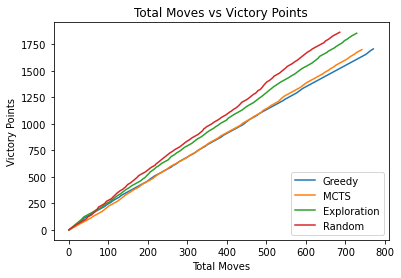

In [203]:
#Plot the data
plt.plot(sum_stats["red"], label="Greedy")
plt.plot(sum_stats["blue"], label="MCTS")
plt.plot(sum_stats["green"], label="Exploration")
plt.plot(sum_stats["yellow"], label="Random")
plt.xlabel("Total Moves")
plt.ylabel("Victory Points")
plt.title("Total Moves vs Victory Points")
plt.legend(loc="lower right")